#Problem#1 : Bangla Hand Written Digit Recognizer
Applying **Neural Network / Deep Neural Network** for the **NumtaDB** dataset and build a multiclass classification model that can recognize `[0-9]` Bengali handwritten digits with different hyperparameter settings. 
##Neural Network / Deep Neural Network:
When we hear the name Neural Network, we feel that it consist of many and many hidden layers but there is a type of neural network with a few numbers of hidden layers. Shallow neural networks consist of only 1 hidden layer.
<div align="center">
<img src="https://drive.google.com/uc?id=1XVCMw53tNG8PdhVYoA4Dpds_j4SL8XTl" width="300">
</div>
On the other hand, deep neural networks consist of many hidden layers.
<div align="center">
<img src="https://drive.google.com/uc?id=1K502pEPXeVQ1eQkQWATNeBpOW7S8ZISj" width="400">

</div>


###Neuron:
The neuron is the atomic unit of a neural network. Given an input, it provides the output and passes that output as an input to the subsequent layer.A neuron can be thought of as a combination of 2 parts:
The first part computes the output Z, using the inputs and the weights.
The second part performs the activation on Z to give out the final output A of the neuron.
###Hidden Layer:
The hidden layer comprises of various neurons, each of which performs the above 2 calculations.
##Dataset: 
One of the key topics of NLP is optical character recognition (OCR). To build an OCR in Bengali language, digit classification provides a convenient starting point. **NumtaDB** s a large dataset (85,000+) of Bengali digits which can be used by researchers for benchmarking their algorithm.

<div align="center">
<img src="https://drive.google.com/uc?id=1LvkNwV1My2RniR_JsbasBET1fa97eMQu" width="400">
</div>

**Dataset Link:** https://www.kaggle.com/BengaliAI/numta/

- **input dimension:**
  - Size of an image: $28 \times 28 = 784$
- **output dimension: 10**
  - 0,1,2,3,4,5,6,7,8,9


The steps to implement bangla hand written digit recognizer will be the following:

##Step#1: Load the dataset
The NumtaDb dataset is directly loaded from Kaggle. 

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anikatanzimaboni","key":"13fc7f14dc7fd8e9f087e64c6b2a14f2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # changing permission

In [ ]:
!kaggle datasets download -d BengaliAI/numta

100% 1.91G/1.91G [00:18<00:00, 20.0MB/s]
100% 1.91G/1.91G [00:18<00:00, 109MB/s] 


**numta.zip** file is downloaded from Kaggle directly. After unzipping it, we get the actual dataset.

In [ ]:
from zipfile import ZipFile
f_name= 'numta.zip'
with ZipFile(f_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import os
from os import path
import shutil

In the dataset, the sources are labeled from 'a' to 'e'. The training sets have separate subsets depending on the source of the data (training-a, training-b, etc.) and the details are also in different csv files (training-a.csv, training-b.csv, etc.)

In [ ]:
def showRawTrainingSamples(csv_filename):
  df = pd.read_csv(csv_filename)
  print(csv_filename)
  print(df.columns)
  return df

In [ ]:
import pandas as pd
a_csv = showRawTrainingSamples('training-a.csv')
b_csv = showRawTrainingSamples('training-b.csv')
c_csv = showRawTrainingSamples('training-c.csv')
d_csv = showRawTrainingSamples('training-d.csv')
e_csv = showRawTrainingSamples('training-e.csv')

training-a.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-b.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-c.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-d.csv
Index(['original filename', 'scanid', 'digit', 'num', 'database name original',
       'database name', 'filename'],
      dtype='object')
training-e.csv
Index(['filename', 'original filename', 'districtid', 'institutionid',
       'gender', 'age', 'datestamp', 'scanid', 'digit',
       'database name original', 'database name'],
      dtype='object')


From the csv files, we only need the information of the file names and their labels which column names are '**filename**' and '**digit**' respectively. So we truncate the data.

In [ ]:
def truncateColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print('Done')
  return csv_file

In [ ]:
a_csv = truncateColumns(a_csv)
b_csv = truncateColumns(b_csv)
c_csv = truncateColumns(c_csv)
d_csv = truncateColumns(d_csv)
e_csv = truncateColumns(e_csv)

Done
Done
Done
Done
Done


All the csv files are merged into one for further process. So, in total, there are 72045 data for training and testing the model.

In [ ]:
total_csv = [a_csv,b_csv,c_csv,d_csv,e_csv]
merged_csv = pd.concat(total_csv)
print(len(merged_csv))

72045


Similarly, all  the images from different directory are merged into one directory named "**trainAll2**".

In [ ]:
TRAIN_PATH = 'trainALL2'
os.mkdir(TRAIN_PATH) #creating the directory

def processImages(folder_name):
  src = folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) #images are copied to trainAll2


In [ ]:

processImages('training-a')
print('A Done')
processImages('training-c')
print('C Done')
processImages('training-d')
print('D Done')

A Done
C Done
D Done


In [ ]:
processImages('training-b')
print('B Done')
processImages('training-e')
print('E Done')

B Done
E Done


##Step#2: Prepare (augment) the dataset
The loaded dataset is still non trival. PyTorch provides many tools to make data loading easy and hopefully, to make the code more readable. 


In [ ]:
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

###Custom Dataset Class

**`torch.utils.data.Dataset`** is an abstract class representing a dataset. To prepare the dataset, we need a **custom Dataset Class**. Our custom dataset should inherit Dataset and override the following methods:

- **`__len__`** so that len(dataset) returns the size of our dataset.

- **`__getitem__`** to support the indexing such that dataset[i] can be used to get ith sample. 
We will read the csv in` __init__` but leave the reading of images to `__getitem__`.


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform

        """
            df : Path to the csv file with annotations.
            root : Directory with all the images.
            transform : Optional transform to be appliedon a sample.
        """
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

###Compose Transforms
The samples are not of the same size. Our model expect the images of a fixed size. `torchvision.transforms.Compose` is a simple callable class which allows us to do this.

- **Resize((28,28))** resize/crop the image to 28*28 dimension
- **ToTensor()** takes a PIL image (or np.int8 NumPy array) with shape (n_rows, n_cols, n_channels) as input and returns a PyTorch tensor with floats between 0 and 1 and shape (n_channels, n_rows, n_cols).
- **Normalize(mean,std)** subtracts the mean and divides by the standard deviation of the floating point values in the range [0, 1].
- As mean =0.5 and std =0.5, an image is normalized to [-1,1] here.

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

'''Instantiate the Dataset Class'''
train_dataset  = Dataset(merged_csv, TRAIN_PATH, train_transform)
test_dataset = Dataset(merged_csv, TRAIN_PATH, test_transform)

print("Trainig Samples: ",len(train_dataset))

Trainig Samples:  72045


##step#3 : Make Data Iterable
- We split the training set to 90% and test set to 10%. That means a 90:10 ratio. To split the data we have used **`torch.utils.data.sampler`** class.
- We will use the **DataLoader** class to make our dataset iterable. 

In [ ]:
import numpy as np
#batch size

#batch_size = 32
batch_size = 64

# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
len_train = len(train_dataset)

# mix data
# index of num of train
indices = list(range(len_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * len_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=train_sampler) #No need to shuffle here, because sampler has shuffled data already

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:1014
Test dataloader:113


Showing the information of one sample data and the images:

In [ ]:
'''Informations of one sample data'''
# One Image Size
print(train_dataset[22][0].size())
print(train_dataset[22][0].numpy().shape)
# First Image Label
print(train_dataset[22][1])

torch.Size([1, 28, 28])
(1, 28, 28)
6


Label:
5


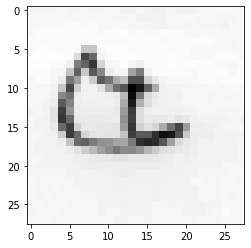

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

print("Label:")
print(train_dataset[0][1])
show_img = train_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

Label:
5


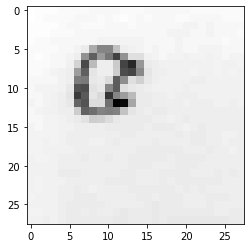

In [ ]:
print("Label:")
print(train_dataset[201][1])

show_img = train_dataset[201][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

##Step#4: Create the Model Class

In order to set up the model class, we need to initialize the model type and declare the forward pass. 

We initialize our model with this linear layer: **`torch.nn.Linear(input_size, num_classes)`** which
applies a linear transformation to the incoming data:  $y=W^T∗x+b$.

Parameters:

- input_size – size of each input sample (i.e. size of x)
- num_classes – size of each output sample (i.e. size of y)
- bias – If set to False, the layer will not learn an additive bias. Default: True

In this setting, We have initiliazed our model with one hidden layer. And in the hdden layer we have used **ReLu** as activation fuction. It Applies the rectified linear unit function element-wise:

$\text{ReLU}(x) = (x)^+ = \max(0, x) $

<div align="center">
<img src="https://drive.google.com/uc?id=1wKFWSYXY7leTqAxoeKBtpyMtJCqEF1bs" width="500">
</div>

Next is to define the forward pass function. The forward pass refers to the calculation process of the output data from the input. 



The complete model class is defined below:

In [ ]:
####one hidden layer with relu activation

class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer
        self.linear_1 = nn.Linear(input_size, num_hidden)

        ### Non-linearity
        self.relu = nn.ReLU()

        ### Output layer
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        # Linear layer
        out  = self.linear_1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


##Step#5:Instantiate the Model Class

####**Modelparameter:**
Model parameters are learned during training when we optimize a loss function using something like gradient descent.

####**Hyperparameter:**
Parameters which define the model architecture are referred to as hyperparameters. Hyperparameters are not model parameters and they cannot be directly trained from the data. 
These values are fixed before the training of the data begins. They deal with parameters such as learning_rate,num_iters etc.

- **learning_rate**: How quickly the model should be able to learn, how complicated the model is, and so on. 
- **num_iters**: It is used to specify the number of combinations that are randomly tried. If num_iters is too less, finding the best combination is difficult, and if num_iters is too large, the processing time increases. It is important to find a balanced value for ‘n_iter’.
  - **1 iteration**: One mini-batch forward & backward pass. That means a parameter (wights and biases) update. 
- **minibatch**:  Number of examples in 1 iteration
- **epochs**: How many times we are running the dataset

  - **1 epoch**: Running through the whole dataset once
- **num_hiddden**: number of nodes in a hidden layer. It can vary in every hidden layer.

Before instantiation, we’ll initialize some hyperparameters like following.

In [ ]:
# Hyperparameters

batch_size = 32
num_iters = 16000
input_dim = 28*28 # num_features = 784
num_hidden = 100
output_dim = 10

learning_rate = 0.1
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Instantiating the model class and enabling GPU:

In [ ]:
model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

NeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (linear_out): Linear(in_features=100, out_features=10, bias=True)
)

##Step#6: Construct loss and optimizer (select from PyTorch API)

We need **Cross Entropy Loss** to calculate our loss before we backpropagate and update our parameters.

`criterion = nn.CrossEntropyLoss() ` 

Here we used **Stochastic gradient descent(SGD)** as our optimizer that makes forward and backward propagation for every record.  Although there are different optimizers SGD can work well for our model.

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

##Step #7 : Training: forward, loss, backward, step




  




- Calling `.backward()` mutiple times accumulates the gradient (**by addition**) for each parameter. 

- This is why you should call `optimizer.zero_grad()` after each .step() call. 

- Note that following the first `.backward` call, a second call is only possible after you have performed another **forward pass**.

- `optimizer.step` performs a parameter update based on the current gradient (**stored in .grad attribute of a parameter**)

Simplified equation:

- `parameters = parameters - learning_rate * parameters_gradients`
- parameters $W$ and $b$ in ($y = W^T * x + b$)
- $\theta = \theta - \eta \cdot \nabla_\theta$  [ General parameter $\theta$ ]
  *  $\theta$ : parameters (our variables)
  *  $\eta$ : learning rate (how fast we want to learn)
  *  $\nabla_\theta$ : parameters' gradients



###Setting 1: One Layer Neural Network with ReLU Activation (Accuracy 52.51%)
**batch =32,iteration = 16000, learning rate=0.1, nodes per hidden layer= 100**






In [ ]:
'''
TRAIN THE MODEL
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)
iteration_loss = []

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

7
Iteration: 500. Loss: 1.861427903175354. Accuracy: 27.85952248750694
Iteration: 1000. Loss: 2.025313138961792. Accuracy: 27.942809550249862
Iteration: 1500. Loss: 1.9924695491790771. Accuracy: 28.206551915602443
Iteration: 2000. Loss: 1.7892346382141113. Accuracy: 29.44197667962243
Iteration: 2500. Loss: 1.928159475326538. Accuracy: 32.662409772348695
Iteration: 3000. Loss: 2.1574325561523438. Accuracy: 34.14769572459745
Iteration: 3500. Loss: 1.7301126718521118. Accuracy: 32.648528595224874
Iteration: 4000. Loss: 1.527727484703064. Accuracy: 35.20266518600777
Iteration: 4500. Loss: 1.700987696647644. Accuracy: 28.345363686840646
Iteration: 5000. Loss: 1.4726285934448242. Accuracy: 31.82953914491949
Iteration: 5500. Loss: 1.6808249950408936. Accuracy: 39.519711271515824
Iteration: 6000. Loss: 1.8053841590881348. Accuracy: 33.24541921154914
Iteration: 6500. Loss: 1.5471291542053223. Accuracy: 35.82731815657968
Iteration: 7000. Loss: 1.4173548221588135. Accuracy: 40.56079955580233
Iter

In [ ]:
print(len(train_dataset))
print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

72045
Iteration: 14189. Loss: 1.6792848110198975. Accuracy: 52.51249305941144


#### Plot of predicted and actual values

[1.861427903175354, 2.025313138961792, 1.9924695491790771, 1.7892346382141113, 1.928159475326538, 2.1574325561523438, 1.7301126718521118, 1.527727484703064, 1.700987696647644, 1.4726285934448242, 1.6808249950408936, 1.8053841590881348, 1.5471291542053223, 1.4173548221588135, 1.6715525388717651, 1.6161842346191406, 1.7833518981933594, 1.6306277513504028, 1.7006288766860962, 1.9091105461120605, 1.6433558464050293, 1.8610382080078125, 1.3448554277420044, 1.6404788494110107, 1.5545399188995361, 2.0921754837036133, 1.5571677684783936, 1.5813096761703491]


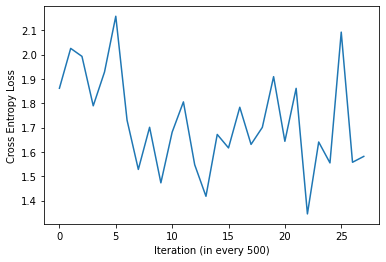

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
iteration_loss=[1.861427903175354,2.025313138961792,1.9924695491790771,1.7892346382141113,1.928159475326538,2.1574325561523438,1.7301126718521118,1.527727484703064,1.700987696647644,1.4726285934448242,1.6808249950408936,1.8053841590881348,1.5471291542053223,1.4173548221588135,1.6715525388717651,1.6161842346191406,1.7833518981933594,1.6306277513504028,1.7006288766860962,1.9091105461120605,1.6433558464050293,1.8610382080078125,1.3448554277420044,1.6404788494110107,1.5545399188995361,2.0921754837036133,1.5571677684783936,1.5813096761703491]
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

root_path = '/content/gdrive/My Drive/Soft Computing/'

Mounted at /content/gdrive


#### Saving Model to Directory

In [ ]:
import pickle
save_model = True


if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'A2_Problem1_setting1.pkl') 

#### Loading Model 

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'A2_Problem1_setting1.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


Accuracy: 52.51%

###Setting2: Two Layer Neural Network (Deep) with ReLU Activation (Accuracy 61.76%)
**batch =32,iteration = 26000, learning rate=0.01, nodes per hidden layer= 100**





In [ ]:
# Hyperparameters

batch_size = 32
num_iters = 26000
input_dim = 28*28 # num_features = 784
num_hidden = 100
output_dim = 10

learning_rate = 0.01
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In this setting, two hidden layer is used. And in every layer ReLU activation function is used. 

It Applies the rectified linear unit function element-wise:

$ReLU(x)=(x)^+ =max(0,x)$

<div align="center">
<img src="https://drive.google.com/uc?id=1wKFWSYXY7leTqAxoeKBtpyMtJCqEF1bs" width="500">
</div>

In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

11


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
iteration_loss=[]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.283236265182495. Accuracy: 18.309272626318712
Iteration: 1000. Loss: 2.093052625656128. Accuracy: 25.31926707384786
Iteration: 1500. Loss: 2.013409376144409. Accuracy: 28.90061077179345
Iteration: 2000. Loss: 1.9171744585037231. Accuracy: 31.60744031093837
Iteration: 2500. Loss: 2.045335054397583. Accuracy: 35.42476401998889
Iteration: 3000. Loss: 2.2089595794677734. Accuracy: 32.31538034425319
Iteration: 3500. Loss: 1.8708444833755493. Accuracy: 32.60688506385341
Iteration: 4000. Loss: 2.0584616661071777. Accuracy: 39.533592448639645
Iteration: 4500. Loss: 1.7943756580352783. Accuracy: 38.686840644086615
Iteration: 5000. Loss: 1.7938646078109741. Accuracy: 37.93725707940033
Iteration: 5500. Loss: 1.4816067218780518. Accuracy: 39.75569128262077
Iteration: 6000. Loss: 1.723716139793396. Accuracy: 37.38200999444753
Iteration: 6500. Loss: 1.6426104307174683. Accuracy: 42.754025541365905
Iteration: 7000. Loss: 1.7968416213989258. Accuracy: 43.281510272071074
Iterati

#### Plot of predicted and actual values

[2.283236265182495, 2.093052625656128, 2.013409376144409, 1.9171744585037231, 2.045335054397583, 2.2089595794677734, 1.8708444833755493, 2.0584616661071777, 1.7943756580352783, 1.7938646078109741, 1.4816067218780518, 1.723716139793396, 1.6426104307174683, 1.7968416213989258, 1.7021019458770752, 1.6595720052719116, 1.7423474788665771, 1.5158791542053223, 1.6878864765167236, 1.6660866737365723, 1.4517501592636108, 1.7640453577041626, 1.8323110342025757, 1.3349357843399048, 1.5728909969329834, 1.5361607074737549, 1.243141770362854, 1.2611865997314453, 1.2886356115341187, 0.9172056913375854, 1.4981738328933716, 1.3230901956558228, 1.496582269668579, 1.3439511060714722, 1.1702704429626465, 1.266524314880371, 0.9589886665344238, 1.108884572982788, 1.0944955348968506, 1.2846752405166626, 1.3156049251556396, 1.1964333057403564, 1.5398160219192505, 1.1088730096817017]


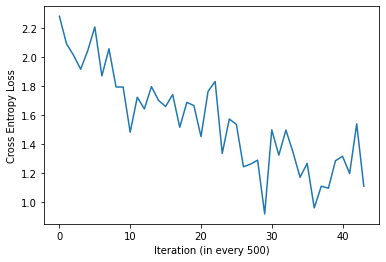

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

#### Saving Model to Directory

In [ ]:
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'A2_Problem1_setting2.pkl') 

#### LoadingModel

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'A2_Problem1_setting2.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


*Accuracy*: 61.76%



###Setting 3: Three Layer Neural Network (Deep) with LeakyReLU Activation (Accuracy 63.94%)

**batch =64, iteration = 12000, learning rate=0.05, nodes per hidden layer= 100**


In [ ]:
# Hyperparameters

batch_size = 64
num_iters = 12000
input_dim = 28*28 # num_features = 784
num_hidden = 100
output_dim = 10

learning_rate = 0.05
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Here we have used three hidden layers. And in each layer we have used LeakyReLU activation function. 
This function applies the element-wise function:

$\text{LeakyReLU}(x) = \max(0, x) + \text{negative_slope} * \min(0, x)$

or

$\text{LeakyRELU}(x) = \begin{cases} x, & \text{ if } x \geq 0 \\ \text{negative_slope} \times x, & \text{ otherwise } \end{cases}$


<div align="center">
<img src="https://drive.google.com/uc?id=1mrXVaeMrCaMXDRy8-ZrBkyKY-qeYq9ki" width="500">
</div>
​	

In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

10


In [ ]:

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.leaky_relu_1 = nn.LeakyReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.leaky_relu_2 = nn.LeakyReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.leaky_relu_3 = nn.LeakyReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.leaky_relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.leaky_relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.leaky_relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iteration_loss=[]
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.0134716033935547. Accuracy: 23.237090505274846
Iteration: 1000. Loss: 1.9671496152877808. Accuracy: 26.62409772348695
Iteration: 1500. Loss: 1.5631868839263916. Accuracy: 36.28539700166574
Iteration: 2000. Loss: 1.846399188041687. Accuracy: 38.02054414214325
Iteration: 2500. Loss: 1.699814796447754. Accuracy: 38.52026651860078
Iteration: 3000. Loss: 2.0444796085357666. Accuracy: 36.89616879511382
Iteration: 3500. Loss: 1.6533279418945312. Accuracy: 43.920044419766796
Iteration: 4000. Loss: 1.5713564157485962. Accuracy: 48.153803442531924
Iteration: 4500. Loss: 2.072197198867798. Accuracy: 32.967795669072736
Iteration: 5000. Loss: 1.4604921340942383. Accuracy: 51.34647418101055
Iteration: 5500. Loss: 1.520715355873108. Accuracy: 51.943364797334816
Iteration: 6000. Loss: 1.6268835067749023. Accuracy: 52.19322598556358
Iteration: 6500. Loss: 1.4062893390655518. Accuracy: 43.93392559689062
Iteration: 7000. Loss: 1.420956015586853. Accuracy: 57.259855635757916
Iterat

####Plot of predicted and actual values

[2.0134716033935547, 1.9671496152877808, 1.5631868839263916, 1.846399188041687, 1.699814796447754, 2.0444796085357666, 1.6533279418945312, 1.5713564157485962, 2.072197198867798, 1.4604921340942383, 1.520715355873108, 1.6268835067749023, 1.4062893390655518, 1.420956015586853, 1.4080015420913696, 1.0509029626846313, 1.1001290082931519, 1.416479229927063, 1.2896497249603271, 0.8878252506256104]


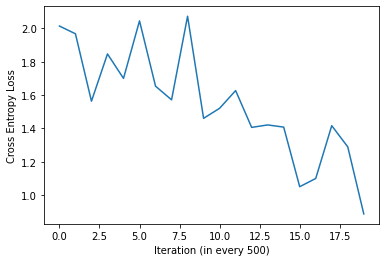

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

####Saving Model to Directory

In [ ]:
import pickle
save_model = True


if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'A2_Problem1_setting3.pkl') 

####Loading Model

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'A2_Problem1_setting3.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


Accuracy: 63.94% 

###Setting 4: Four Layer Neural Network (Deep) with LeakyReLU Activation (Accuracy 73.73%)

**batch =64, iteration = 18000, learning rate=0.1, nodes per hidden layer= 200**





In [ ]:
# Hyperparameters

batch_size = 64
num_iters = 18000
input_dim = 28*28 # num_features = 784
num_hidden=200
output_dim = 10

learning_rate = 0.1
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Here we have used three hidden layers. And in each layer we have used LeakyReLU activation function. 
This function applies the element-wise function:

$\text{LeakyReLU}(x) = \max(0, x) + \text{negative_slope} * \min(0, x)$

or

$\text{LeakyRELU}(x) = \begin{cases} x, & \text{ if } x \geq 0 \\ \text{negative_slope} \times x, & \text{ otherwise } \end{cases}$



<div align="center">
<img src="https://drive.google.com/uc?id=1mrXVaeMrCaMXDRy8-ZrBkyKY-qeYq9ki" width="500">
</div>

In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)


15


In [ ]:

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.leaky_relu_1 = nn.LeakyReLU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.leaky_relu_2 = nn.LeakyReLU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.leaky_relu_3 = nn.LeakyReLU()

        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.leaky_relu_4 = nn.LeakyReLU()

        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.leaky_relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.leaky_relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.leaky_relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.leaky_relu_4(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iteration_loss=[]
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.8158823251724243. Accuracy: 25.735702387562466
Iteration: 1000. Loss: 1.7685785293579102. Accuracy: 34.1893392559689
Iteration: 1500. Loss: 1.7467007637023926. Accuracy: 33.74514158800666
Iteration: 2000. Loss: 1.565964698791504. Accuracy: 40.13048306496391
Iteration: 2500. Loss: 1.7435005903244019. Accuracy: 37.63187118267629
Iteration: 3000. Loss: 1.8340883255004883. Accuracy: 35.60521932259856
Iteration: 3500. Loss: 1.738470196723938. Accuracy: 39.630760688506385
Iteration: 4000. Loss: 1.4815887212753296. Accuracy: 40.782898389783455
Iteration: 4500. Loss: 2.0211167335510254. Accuracy: 34.952803997779014
Iteration: 5000. Loss: 1.2673059701919556. Accuracy: 47.681843420322046
Iteration: 5500. Loss: 1.534876823425293. Accuracy: 43.22598556357579
Iteration: 6000. Loss: 1.6946238279342651. Accuracy: 44.947251526929485
Iteration: 6500. Loss: 1.2762389183044434. Accuracy: 55.02498611882287
Iteration: 7000. Loss: 1.3843986988067627. Accuracy: 56.32981676846197
Itera

####Plot of predicted and actual values

[1.8158823251724243, 1.7685785293579102, 1.7467007637023926, 1.565964698791504, 1.7435005903244019, 1.8340883255004883, 1.738470196723938, 1.4815887212753296, 2.0211167335510254, 1.2673059701919556, 1.534876823425293, 1.6946238279342651, 1.2762389183044434, 1.3843986988067627, 1.4949554204940796, 1.0939726829528809, 0.9988976120948792, 1.2917003631591797, 1.041834831237793, 1.139032244682312, 0.7764773964881897, 0.9993008375167847, 0.8446411490440369, 0.9518325328826904, 0.696003258228302, 0.6278815269470215, 0.7340837121009827, 0.6262462139129639, 0.9960370659828186, 0.7881004810333252]


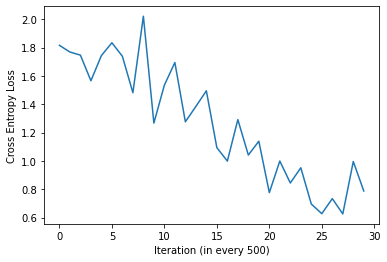

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

####Saving Model to directory

In [ ]:
import pickle
save_model = True


if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'A2_Problem1_setting5.pkl') 

####Loading Model

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'A2_Problem1_setting5.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


Accuracy 73.73%

##Analyzing the Tuning of Hyperparameters:


| Setting No.| Batch size | Dataset per batch | Iterations| Epochs| Learning rate    |Number of hideen layer|Number of Nodes per Hiddden layer|Activation Function |Accuracy| 
| :-------------: | :----------: | :-----------: | :-------------: | :----------: | :-----------: | :-----------: | :-----------: |:-----------: |:-----------: |
| 01 | 32 | 2253 |  16000 |  7 | 0.1   | 1|100|ReLU |52.51%   |
| 02 | 32 | 2253 |  26000 | 11 | 0.01    | 2|100|ReLU|61.76%   |
| 03 | 64 | 1127 |  12000 | 10 | 0.05    | 3|100|LeakyReLU|63.94%   |
| 04 | 64 | 1127 |  18000 | 15 | 0.1    | 4|200|LeakyReLU|**73.73%** |





Here, we can see the best accuracy among 4 settings is **73.73**%. We can analyze this taking each parameter in comparison.

- **Analyzing according to number of hidden layers:**

<div align="center">
<img src="https://drive.google.com/uc?id=1RIbv-I_1kxsT8tWO-PUUKNHmyI3tphJf" width="300">
</div>

Among the seetings, we can see that the more we increase the number of hidden layer the more accuracy increases. It can say that if the hlayer number increases, the networks becomes more stronger and gives better result. But, it also depends  on the size of the dataset. For smaller experiment , a very complicated model becomes unnecessary and the result becomes overfitted.

- **Analyzing according to the number of nodes per hidden layer:**

In per hidden layer, the number of nodes may vary. By incresing the number of nodes, accuracy might increase. But again it depends on the size of the dataset. For smaller experiment , a very complicated model becomes unnecessary and the result becomes overfitted.

- **Analyzing according to activation function:**

There are various kind of activation function from pytroch we can use.  [**LINK**](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) We have already known that ReLU is better than Sigmoid and Tanh and it is better to start with ReLU activation function.Because the calculation load is less than the sigmoid and hyperbolic tangent 
functions has led ReLu to a higher preference for multi-layer networks. 

 In two setting we have used **ReLU** and in two other we have used **LeakyReLU** activation function. and we can see that LeakyReLu gives better result  than ReLU. Beacuse this variation of 
ReLU has a small positive slope in the negative 
area, so it does enable backpropagation, even for 
negative input values. This leaky value is given as 
a value of 0.01 if not +ve. 

- **Analyzing according to learning rate:**


<div align="center">
<img src="https://drive.google.com/uc?id=14UHEwXqnicCx1POOEDijdELfKkY2hss6" width="300">
</div>


We can see the more learning rate increases, the more accuracy increases. From this it is said that, A learning rate that is too low will take a long time to converge and not give a good result. But sometime higher learning rate may result to miss the global minima.

- **Analyzing according to epochs:**

<div align="center">
<img src="https://drive.google.com/uc?id=1B1o2tKmzhUarB3SWohlXD4_nfVJHa3Ba" width="300">
</div>

In general, the models improve with more epochs of training, to a point. They'll start to plateau in accuracy as they converge. But, here comparing setting 2 and 4, we can see as the epoch increases , accuracy decreases. So, we can say it is dataset dependent. 


- **Analyzing according to batch size and iterations:**


<div align="center">
<img src="https://drive.google.com/uc?id=1E2o0RQDpME1AeTyrcY4zoq7p0PyudGtw" width="300">
</div>


In general, larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster.



- **Analyzing the graphs of all the settings according to loss functions:**

<div align="center">
<img src="https://drive.google.com/uc?id=1aJqyPqmz4z2Dxkc4fTaFjnkU5nHDklTO" width="800">
</div>


From the above graphs, we can see that the more the model gets trained, the more loss function decreaes i.e. gives better result. We can also see, one on hidden layer the loss function flauctes more frequently. But the more hidden layer increases, the graph goes lower .




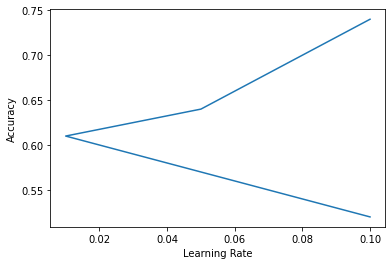

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
X=[0.1,0.01,0.05,0.1]
Y=[0.52,0.61,0.64,0.74]
plt.plot(X,Y)
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')
plt.show()

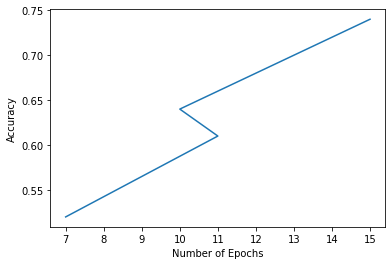

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
X=[7,11,10,15]
Y=[0.52,0.61,0.64,0.74]
plt.plot(X,Y)
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.show()

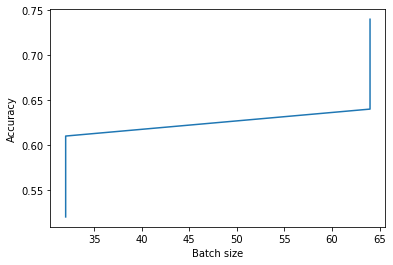

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
X=[32,32,64,64]
Y=[0.52,0.61,0.64,0.74]
plt.plot(X,Y)
plt.ylabel('Accuracy')
plt.xlabel('Batch size')
plt.show()

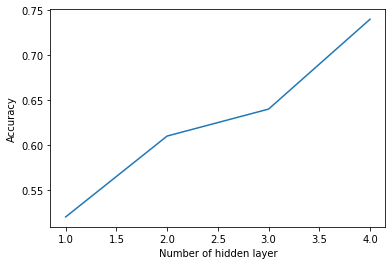

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
X=[1,2,3,4 ]
Y=[0.52,0.61,0.64,0.74]
plt.plot(X,Y)
plt.ylabel('Accuracy')
plt.xlabel('Number of hidden layer')
plt.show()